In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

import wandb 

In [27]:
# Replace argparse with a dictionary
args = {

    "seed": 42, 

    
    'dataset_transform': [],  # Example list of transformations
    'numbers_list': [0, 1, 3, 4, 5, 6, 7],  # List of integers for class selection
    'N': 20,  # Number of distinct training images per class
    'supervision_label_val': 10,  # An integer value for supervision

    # -----graph-----
    'num_internal_nodes': 1000,  # Number of internal nodes
    'graph_type': 'fully_connected',  # Type of graph

    # -----model-----
    'model_type': 'PC',  # Predictive model type
    'weight_init': 0.001,  # Weight initialization
    'T': 40,  # Number of iterations for gradient descent
    'lr_values': 0.1,  # Learning rate for values
    'lr_weights': 0.0001,  # Learning rate for weights
    'activation_func': 'swish',  # Activation function

    # -----learning-----
    'epochs': 5,  # Number of epochs
    'batch_size': 2,  # Batch size
    'seed': 42,  # Random seed
    'optimizer': 0.01,  # Optimizer, can be True with a float value

    # -----logging-----
    'use_wandb': 'disabled',  # Wandb mode
}

# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument


[]


In [28]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)


In [29]:
import sys
sys.path.append(os.path.abspath("../scr"))


# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"

    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": 

      {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"]
      },      
  
}

if graph_params["graph_type"]["name"] == "stochastic_block":
  assert graph_params["internal_nodes"] == (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

from dataset import CustomGraphDataset

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)

dataset_params["batch_size"] = args.batch_size
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


from helper.plot import plot_adj_matrix

single_graph = custom_dataset_train.edge_index


print("--------------Init DataLoader --------------------")
train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                          generator=generator_seed,
                          num_workers=1
                          )




NUM_SENSORY = 28*28  # 10

## TODO: FIX HOW TO DO THIS 
#### ---------------------------------------------------------------------------------------------------------------
# sensory_indices    = range(NUM_SENSORY)
# internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# supervision_indices = None

# if dataset_params["supervised_learning"]:
#     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
#     supervision_indices = label_indices
#     num_vertices += 10

# print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# print("num_vertices \t\t:", num_vertices)

# if dataset_params["supervised_learning"]:
#   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# else:
#   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
#### ---------------------------------------------------------------------------------------------------------------

num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices



print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    

    full_batch = edge_index

    break




######################################################################################################### 
####                                            VALIDATION                                          #####
######################################################################################################### 
 
# from helper.validate_MP import validate_messagePassing
# validate_messagePassing()

######################################################################################################### 
####                                            FIND OPTIMAL LR                                     #####
######################################################################################################### 
""" 
SKIPPING FOR NOW, see local  
"""



######################################################################################################### 
####                                              Model  (setup)                                    #####
######################################################################################################### 

# lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# lr_gamma, lr_alpha =  (0.1, 0.00001)


model_params = {
    
    'num_vertices': num_vertices,
    'sensory_indices': (sensory_indices), 
    'internal_indices': (internal_indices), 
    "supervised_learning": (supervision_indices),

    "lr_params": (args.lr_values, args.lr_weights),
    #   (args.lr_gamma, args.lr_alpha), 
    "T": args.T,
    "graph_structure": custom_dataset_train.edge_index_tensor, 
    "batch_size": train_loader.batch_size, 
    "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
    # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "activation": args.activation_func,  
    "clamping": None , # (0, torch.inf) or 'None' 
 }

# 

learning_params = model_params.copy()
learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
learning_params['internal_indices'] = list(learning_params['internal_indices'])
learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# learning_params['transform'] = transform.to_dict()["transform"]
learning_params['dataset_transform'] = args.dataset_transform

learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    
    raise TypeError('Unknown type:', type(obj))

# combi of learning params and dataset params
params_dict = {**dataset_params, **learning_params}


import json

from datetime import datetime




save_model_params = False

GRAPH_TYPE = graph_params["graph_type"]["name"]    #"fully_connected"
# GRAPH_TYPE = "test"    #"fully_connected"

date_hour = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

model_dir = f"trained_models/test/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"
# model_dir = f"trained_models/{args.model_type.lower()}/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"

# Define the directory path
print("Saving model, params, graph_structure to :", model_dir)

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# For saving, validation, re-creation 
os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "parameter_info"), exist_ok=True)

# For testing the model
os.makedirs(os.path.join(model_dir, "eval"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/generation"), exist_ok=True)
# os.makedirs(os.path.join(model_dir, "reconstruction"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/classification"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/denoise"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/occlusion"), exist_ok=True)

# Monitor during training
os.makedirs(os.path.join(model_dir, "energy"), exist_ok=True)

plot_adj_matrix(single_graph, model_dir, 
                node_types=(sensory_indices, internal_indices, supervision_indices))
plot_adj_matrix(full_batch, model_dir, node_types=None)





Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
Supervised learning
Taking first n=20 digits from each class
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
Creating fully connected directed graph without self connections
self.edge_index torch.Size([2, 3216642])
-----Done-----
1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 1

In [30]:
import wandb 

run = wandb.init(
    mode=args.use_wandb,
    # entity="Erencan Tatar", 
    project=f"PredCod",
    name=f"T_{args.T}_lr_value_{args.lr_values}_lr_weights_{args.lr_weights}_",
    id=f"{model_params_name}_{date_hour}",
    # tags= 
    dir=model_dir,
    

    # tags=["param_search", str(model_params["weight_init"]), model_params["activation"],  *learning_params['dataset_transform']], 
    # Track hyperparameters and run metadata
    config={
        "supervised_learning": (graph_params["supervised_learning"]),

        "lr_params": (args.lr_values, args.lr_weights), 
        "T": args.T,

        "graph_structure": args.graph_type, 
        "model_type": args.model_type.lower(), 
        # "graph_structure": custom_dataset_train.edge_index_tensor, 
        # "include_self_connections": dataset_params['include_self_connections'],
        "batch_size": train_loader.batch_size, 
        "use_learning_optimizer": model_params["use_learning_optimizer"],    # False or [0], [(weight_decay=)]
        "weight_init":  model_params["weight_init"],   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
        "activation":  model_params["activation"],  
        "clamping": model_params["clamping"], # (0, torch.inf) or 'None' 

        "numbers_list":         dataset_params["numbers_list"],    
        "N":                    dataset_params['N'],     # taking the first n instances of each digit or use "all"

        "transform": learning_params['dataset_transform'],
    },
)

# Contains graph edge matrix and other parameters so quite big to open.
if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_full.txt", 'w') as file:
        json.dump(params_dict, file, default=default)
    print('Done')

# Store the exact command-line arguments in a text file
import sys
command = ' '.join(sys.argv)
with open(model_dir +'parameter_info/command_log.txt', 'w') as f:
    f.write(command)

with open('trained_models/current_running.txt', 'w') as f:
    f.write(model_dir)

# Save the (small) dictionary to a text file
params_dict_small = {}
keys_to_copy = ['supervised_learning', 'numbers_list', 'NUM_INTERNAL_NODES',  
                'N',  'batch_size','use_learning_optimizer', 'weight_init', 'activation', ]
# copy value from params_dict to params_dict_small
for key in keys_to_copy:
    params_dict_small[key] = params_dict[key]

if "dataset_transform" in params_dict:
    params_dict_small["dataset_transform"] = params_dict["dataset_transform"]


if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_small.txt", 'w') as file:
        json.dump(params_dict_small, file, default=default)
    print('Done')

print(f"Using batch size of \t: {train_loader.batch_size}")
print("Device \t\t\t:",          device)
print("Model type \t\t:", args.model_type.lower())


Using batch size of 	: 2
Device 			: cuda
Model type 		: pc


In [7]:
batch

DataBatch(x=[3588, 3, 1], edge_index=[2, 6433284], edge_attr=[6433284], y=[2], batch=[3588], ptr=[3])

In [31]:

if args.model_type.lower() == "pc":
        
    from models.PC import PCGNN

    model = PCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)

    print("-----------Loading PC model-----------")

if args.model_type.lower() == "ipc":
        
    from models.IPC import IPCGNN

    model = IPCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)
    print("-----------Loading IPC model-----------")

# Magic
wandb.watch(model, 
            log="all",   # (str) One of "gradients", "parameters", "all", or None
            log_freq=10)


from helper.plot import plot_model_weights


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch0.png')
plot_model_weights(model, save_path)




######################################################################################################### 
####                                              Model  (training)                                 #####
######################################################################################################### 

model.pc_conv1.set_mode("training")

VAL VS K 0.001 0.02360960823249428
------------Using optimizers for values/weights updating ------------
-------------initialize--------------
-------------Activation func set to swish--------------
-----------Loading PC model-----------
Figure saved to trained_models/test/fully_connected/num_internal_nodes_1000_T_40_lr_weights_0.0001_lr_values_0.1_batch_size_2_2024-09-09_16_46_35/parameter_info/weight_matrix_visualization_epoch0.png
vertix 1794
before after 784 1568
before after 1000 2000
before after 10 20
-------------mode training--------------
-------------task None--------------


In [9]:
print(model.pc_conv1.internal_indices[0], model.pc_conv1.internal_indices[-1])
print(len(model.pc_conv1.internal_indices))

print(model.pc_conv1.internal_indices_batch[0], model.pc_conv1.internal_indices_batch[-1])
print(len(model.pc_conv1.internal_indices))

784 3577
2000
784 3577
2000


In [10]:
# assert 1==2 

In [32]:

import time 
torch.cuda.empty_cache()

print(model)      

model = model.to(device)
# assert train_loader.batch_size == 1
print(len(train_loader))
print("Starting training")


# Initialize early stopping and history
earlystop = False
history = {
    "internal_energy_per_epoch": [],
    "sensory_energy_per_epoch": [],
}

# Define the early stopping threshold and OOM warning
threshold_earlystop = 0.05
max_energy_threshold = 1e6

start_time = time.time()

for epoch in range(args.epochs):
    total_loss = 0
    last_loss = 1e10

    if earlystop:
        break

    for idx, (batch, clean) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        try:
            print("Label:", batch.y, "Input Shape:", batch.x.shape)
            model.train()
            model.pc_conv1.restart_activity()

            batch = batch.to(device)
            history_epoch = model.learning(batch)

            # Append energy values to history
            history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
            history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])

            model.pc_conv1.restart_activity()

            print(f"------------------ Epoch {epoch}: Batch {idx} ------------------")

            # Periodic checkpoint saving and plotting


            # Early stopping based on loss change
            if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
                earlystop = True
                print(f"EARLY STOPPED at epoch {epoch}")
                print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
                break

            # Early stopping based on high energy
            if history_epoch["internal_energy_mean"] > max_energy_threshold:
                print("energy :", history_epoch["internal_energy_mean"])
                print("Energy too high, stopping training")
                earlystop = True
                break

            if idx >= 5:
                print("Epoch checkpoint reached, saving model...")

                # model_filename = f"model_state_dict_{epoch}.pth"
                # model_path = os.path.join(model_dir, model_filename)
                # torch.save(model.state_dict(), model_path)


                from helper.plot import plot_energy_during_training

                plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=model_dir,
                                            epoch=epoch)

                break 


        
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print('WARNING: CUDA ran out of memory, skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                torch.cuda.empty_cache()
                raise e

    print(f"Epoch {epoch} / {args.epochs} completed")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
plot_model_weights(model, save_path)

if earlystop:
    print("Stopping program-------")
    # Open the file in write mode
    with open(model_dir + "early_stopped_training.txt", 'w') as file:
        # Write each list to the file

        file.write("Stopped training :\n")
    exit()


PCGNN(
  (pc_conv1): PCGraphConv(
    (prediction_mp): PredictionMessagePassing()
    (values_mp): ValueMessagePassing()
  )
)
21121
Starting training
Done for idx 35269
Done for idx 14667
Done for idx 17279
Done for idx 38398
Label: tensor([6, 3]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Total energy at time 5 / 40 {'internal_energy': 5.883051872253418, 'supervised_energy': 98.6492919921875, 'sensory_energy': 69.32133483886719},:  10%|█         | 4/40 [00:00<00:01, 18.19it/s] 

Done for idx 17515


Total energy at time 7 / 40 {'internal_energy': 4.943842887878418, 'supervised_energy': 98.54586791992188, 'sensory_energy': 68.96249389648438},:  15%|█▌        | 6/40 [00:00<00:01, 17.96it/s]

Done for idx
 12750

Done for idx 13044
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.9036, device='cuda:0') tensor(-0.0144, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0748, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 1
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 0: Batch 0 ------------------
Label: tensor([3, 7]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
Done for idx 28159
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx -------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8788, device='cuda:0') tensor(-0.0136, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0738, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 2
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 0: Batch 1 ------------------
Label: tensor([3, 3]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
41179
Done for idx 2634
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx 21428
Done for idx 39032
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.7510, device='cuda:0') tensor(-0.0292, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1354, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 3
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 0: Batch 2 ------------------
Label: tensor([3, 5]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx 18961
Done for idx 29333
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8590, device='cuda:0') tensor(-0.0210, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1038, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 4
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 0: Batch 3 ------------------
Label: tensor([7, 0]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx 14392
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8670, device='cuda:0') tensor(-0.0200, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1009, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 5
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 0: Batch 4 ------------------
Label: tensor([4, 7]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
Done for idx 21436
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.9070, device='cuda:0') tensor(-0.0105, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0614, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 6
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 0: Batch 5 ------------------
Epoch checkpoint reached, saving model...
Epoch 0 / 5 completed
Done for idx 24213
Done for idx 38475
Done for idx 15978
Done for idx 33394
Label: tensor([4, 7]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Total energy at time 7 / 40 {'internal_energy': 0.9285084009170532, 'supervised_energy': 97.56893157958984, 'sensory_energy': 62.36729431152344},:  12%|█▎        | 5/40 [00:00<00:01, 19.60it/s]

Done for idx 3660


Total energy at time 8 / 40 {'internal_energy': 0.8488646745681763, 'supervised_energy': 97.55778503417969, 'sensory_energy': 62.37716293334961},:  20%|██        | 8/40 [00:00<00:01, 19.77it/s]

Done for idx 37500


Done for idx 17542
Done for idx 15746
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8668, device='cuda:0') tensor(-0.0143, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0721, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 7
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 1: Batch 0 ------------------
Label: tensor([3, 6]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx 30968
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.9009, device='cuda:0') tensor(-0.0159, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0762, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 8
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 1: Batch 1 ------------------
Label: tensor([0, 7]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
Done for idx 36893-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


  0%|          | 0/40 [00:00<?, ?it/s]

Done for idx 26721
Done for idx 11271
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8332, device='cuda:0') tensor(-0.0195, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0952, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 9
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 1: Batch 2 ------------------
Label: tensor([3, 3]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx 20295
Done for idx 26079
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.7478, device='cuda:0') tensor(-0.0267, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1146, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 10
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 1: Batch 3 ------------------
Label: tensor([6, 7]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Done for idx 32145
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8555, device='cuda:0') tensor(-0.0197, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0920, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 11
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 1: Batch 4 ------------------
Label: tensor([5, 1]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
Done for idx 3795
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.9425, device='cuda:0') tensor(-0.0104, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0586, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 12
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 1: Batch 5 ------------------
Epoch checkpoint reached, saving model...
Epoch 1 / 5 completed
Done for idx 4823
Done for idx 6576
Done for idx 37115
Done for idx 34206
Label: tensor([0, 1]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


Total energy at time 7 / 40 {'internal_energy': 3.013108730316162, 'supervised_energy': 97.3077621459961, 'sensory_energy': 86.68025207519531},:  18%|█▊        | 7/40 [00:00<00:01, 19.68it/s]  

Done for idx 8977


Total energy at time 8 / 40 {'internal_energy': 2.8032774925231934, 'supervised_energy': 97.27946472167969, 'sensory_energy': 86.65217590332031},:  18%|█▊        | 7/40 [00:00<00:01, 19.68it/s]

Done for idx 13193


Done for idx 11292
Done for idx 10369
-------------inference done--------------
-------------weight_update--------------
torch.Size([3588]) torch.Size([3588])
Errors / max, mean tensor(9.8249, device='cuda:0') tensor(-0.0215, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.1019, device='cuda:0')
torch.Size([3588]) torch.Size([3588])
leeen 13
--------------------CLAMP THE WEIGHTS TO BE ABOVE ZERO-----------
----------------NO CLAMPING----------------
-------------weight_update done--------------
-------------Restarting activity (weights/pred/errors/values)--------------
------------------ Epoch 2: Batch 0 ------------------
Label: tensor([7, 6]) Input Shape: torch.Size([3588, 3, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
-------------inference--------------
Aaaa torch.Size([3588, 3, 1])


KeyboardInterrupt: 

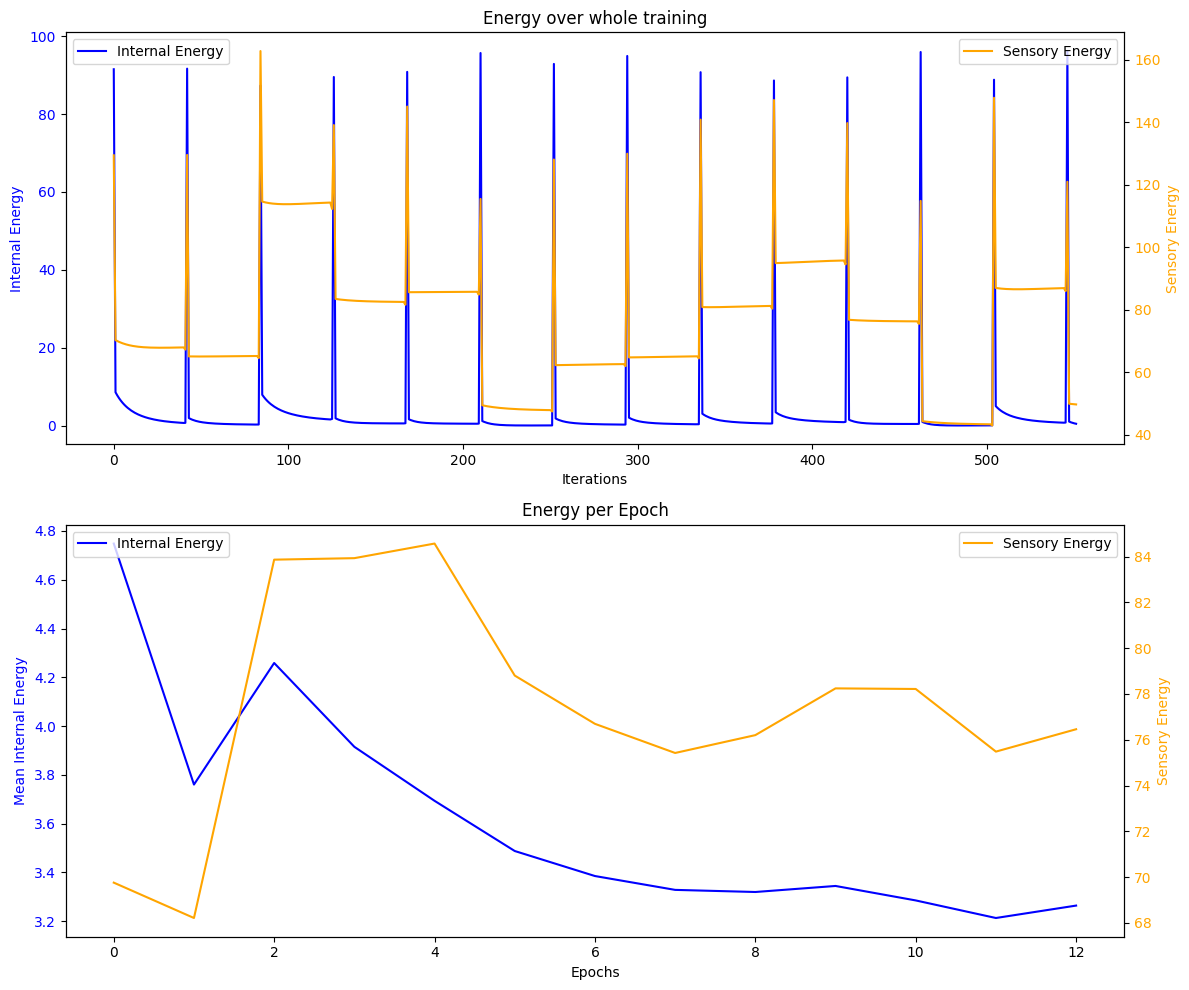

In [33]:
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=None,
                                            epoch=epoch)


In [34]:


# Save model weights 
######################################################################################################### 
####                                            Evaluation (setup)                                  #####
######################################################################################################### 
 
# device = torch.device('cpu')
from eval_tasks import classification, denoise, occlusion, generation #, reconstruction
model.pc_conv1.batchsize = 1


### Make dataloader for testing where we take all the digits of the number_list we trained on ###
dataset_params_testing = dataset_params.copy()

if "batch_size" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["batch_size"]

if "NUM_INTERNAL_NODES" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["NUM_INTERNAL_NODES"]

dataset_params_testing["edge_index"] = custom_dataset_train.edge_index

dataset_params_testing["mnist_dataset"] = mnist_testset
dataset_params_testing["N"] = "all"
dataset_params_testing["supervision_label_val"] = dataset_params["supervision_label_val"]



for key in dataset_params_testing:
    print(key, ":\t ", dataset_params_testing[key])


# CustomGraphDataset params
custom_dataset_test = CustomGraphDataset(graph_params, **dataset_params_testing, 
                                        indices=(num_vertices, sensory_indices, internal_indices, supervision_indices)
                                        )
# dataset_params_testing["batch_size"] = 2

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=True, generator=generator_seed)



mnist_dataset :	  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
supervised_learning :	  True
numbers_list :	  [0, 1, 3, 4, 5, 6, 7]
same_digit :	  False
add_noise :	  False
noise_intensity :	  0.0
N :	  all
edge_index :	  tensor([[   0,    0,    0,  ..., 1793, 1793, 1793],
        [   1,    2,    3,  ..., 1790, 1791, 1792]])
supervision_label_val :	  10
Supervised learning
Taking first n=all digits from each class
-----Done-----
1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 10

In [13]:
# for idx, (noisy_batch, clean_image) in enumerate(test_loader, start=1):
#     noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape

#     torch.rand(noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape).shape
#     break

Done for idx 5893


IndexError: index 2578 is out of bounds for dimension 0 with size 1794

vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([1794, 1])
AAAAAAAAAAAA
model.pc_conv1.values.shape torch.Size([1794, 1])
No vmin vmax
Done for idx 3825
tensor([4])
torch.Size([1794, 3, 1])
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
CHECK tensor([[0.2286],
        [0.1718],
        [0.1540],
        [0.2896],
        [0.1654],
        [0.1909],
        [0.2005],
        [0.2056],
        [0.1540],
        [0.1540]], device='cuda:0')
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS classification
Pass
Aaaa torch.Size([1794, 3, 1])


Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.8879403 -0.11823958
Denoised val 1.0 0.0
tensor([0.1222, 0.1279, 0.1044, 0.1829, 0.1492, 0.1278, 0.1433, 0.1766, 0.1044,
        0.1044], device='cuda:0')
tensor([0.1222, 0.1279, 0.1044, 0.1829, 0.1492, 0.1278, 0.1433, 0.1766, 0.1044,
        0.1044], device='cuda:0')
tensor([[0.1222],
        [0.1279],
        [0.1044],
        [0.1829],
        [0.1492],
        [0.1278],
        [0.1433],
        [0.1766],
        [0.1044],
        [0.1044]], device='cuda:0')
tensor([0.0988, 0.0993, 0.0970, 0.1049, 0.1015, 0.0993, 0.1009, 0.1043, 0.0970,
        0.0970], device='cuda:0')
tensor(3)
---------Done-----------------
TODO output y_pred and y_true to file 
[4] [3]
Classification Metrics:
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


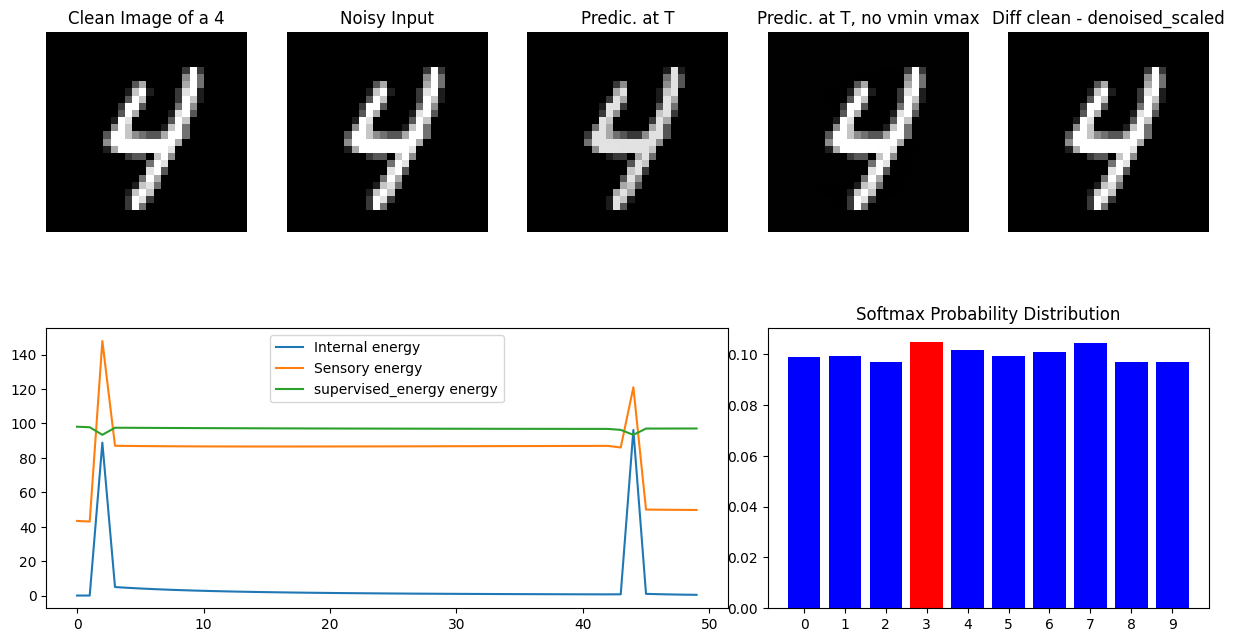

In [37]:

model.pc_conv1.batchsize = 1



test_params = {
    "model_dir": model_dir,
    "T":50,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

In [ ]:


model.pc_conv1.batchsize = 1

######################################################################################################### 
####                                            Evaluation (tasks)                                  #####
######################################################################################################### 
 
test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 5,
    "add_sens_noise": False,
}

# model.pc_conv1.lr_values = 0.1 
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_occ = occlusion(test_loader, model, test_params)

test_params["add_sens_noise"] = True
MSE_values_occ_noise = occlusion(test_loader, model, test_params)

######################################################################################################### 

######################################################################################################### 

test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 6,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_denoise_sup = denoise(test_loader, model, test_params)

test_params["supervised_learning"] = False
MSE_values_denoise = denoise(test_loader, model, test_params)
                            
# MSE_values = denoise(test_loader, model, supervised_learning=True)
# print("MSE_values", MSE_values)
######################################################################################################### 



# # MSE_values = denoise(test_loader, model, supervised_learning=True)
# # print("MSE_values", MSE_values)


# print("accuracy_mean", accuracy_mean)

# print("model_dir", model_dir)

# # write a text file with these 


# # Open the file in write mode
# with open(model_dir + "eval/eval_scores.txt", 'w') as file:
#     # Write each list to the file

#     file.write("MSE_values_denoise_sup:\n")
#     file.write(", ".join(map(str, MSE_values_denoise_sup)) + "\n\n")

#     file.write("MSE_values_denoise:\n")
#     file.write(", ".join(map(str, MSE_values_denoise)) + "\n\n")
    
#     file.write("MSE_values_occ_noise:\n")
#     file.write(", ".join(map(str, MSE_values_occ_noise)) + "\n\n")
    
#     file.write("MSE_values_occ:\n")
#     file.write(", ".join(map(str, MSE_values_occ)) + "\n\n")

#     file.write("accuracy_mean:\n")
#     file.write("y_true: " + ", ".join(map(str, y_true)) + "\n")
#     file.write("y_pred: " + ", ".join(map(str, y_pred)) + "\n")
    
#     file.write(str(accuracy_mean) + "\n\n")


# from datetime import datetime
# # Get the current date and time
# current_datetime = datetime.now()
# # Print the current date and time
# print("Current date and time:", current_datetime)



# wandb.log({"accuracy_mean": accuracy_mean})
# # wandb.log({"energy_sensory": energy["sensory_energy"]})






# wandb.finish()

vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task generation--------------
model.pc_conv1.values.shape torch.Size([1794, 1])
-------------Restarting activity (weights/pred/errors/values)--------------
No vmin vmax
Done for idx 2428
tensor([3])
torch.Size([1794, 3, 1])
omitting setting sensory nodes
labels before torch.Size([10]) tensor([0.0000, 0.6445, 0.0000, 0.0000, 0.8538, 0.0000, 0.0000, 0.0266, 0.0000,
        0.0000], device='cuda:0')
labels after tensor([0.0000, 0.6445, 0.0000, 0.0000, 0.8538, 0.0000, 0.0000, 0.0266, 0.0000,
        0.0000], device='cuda:0')
tensor([[ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
labels model tensor([[ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:

Inference completed.
QUery by condition or query by init
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
Predic. at T, no vmin vmax -0.00688383 -0.024231732
Denoised val 0.34435147 0.30266076
generation_task_3.png
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')


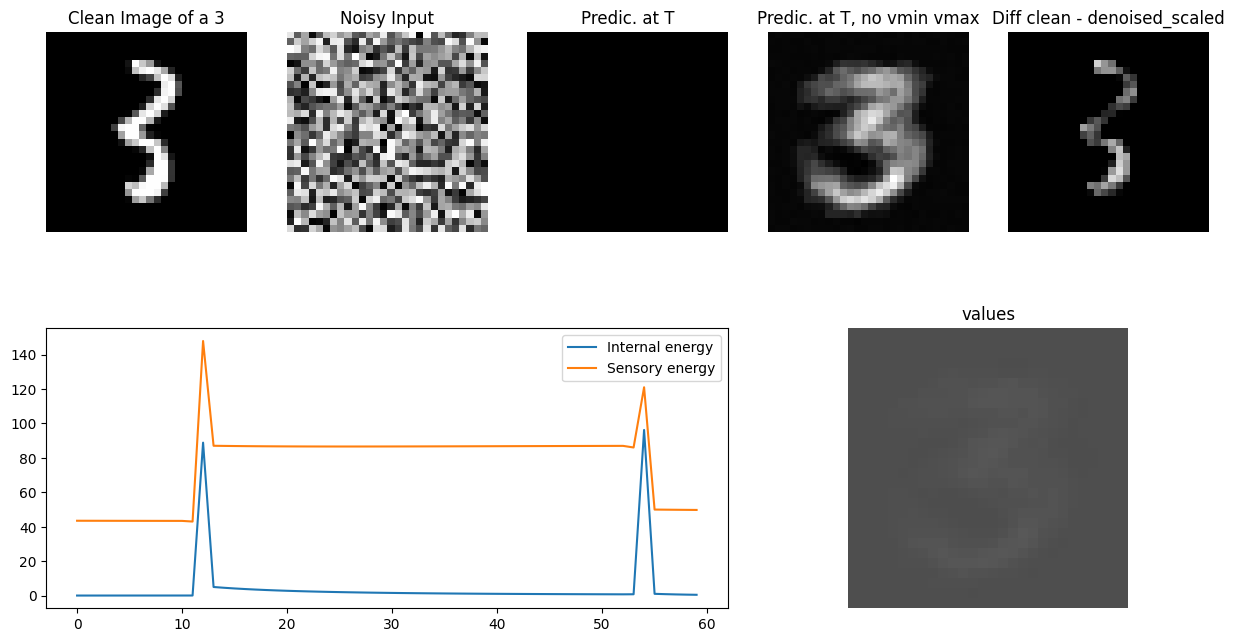

In [44]:

test_params = {
    "model_dir": model_dir,
    "T": 60,
    "supervised_learning":True, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

generation(test_loader, model, test_params)
                            